### This notebook contains early-stage experimentation, exploratory analysis, and feature prototyping.The final, cleaned analysis and modeling pipeline is available on the `main` branch.

## The Data Collection/Extraction Stages.
### The goal is to have audio features for each track as well as # of streams across all platforms. We will attempt to predict the # of streams based on the track's audio features.
1. Pull a sample of metal tracks released starting 2005 from Chartmetric. The data includes Spotify and other platforms' # of streams, as well as ISRC (International Standard Recording Code). This number is shared between multiple versions of the same song (e.g. album vs. single, remastered versions etc.), but belongs to essential the same track.
2. Spotify no longer allows to use its data for AI training and deprecated the API for pulling tracks' audio features, so we will use a third party API - Reccobeats to calculate audio features for each track.
3. Need to create a script to pull audio features from Reccobeats based on ISCRC for each song on the Chartmetric dataset.
4. Since ISRC can pull multiple versions of the same song, need to calculate the mean for each audio feature to closely approximate the most popular version's features. Reccobeats API currently does not provide the song's stream data, so it is not possible to pull only the audio features of the main version. Averaging out accross multiple versions of the song would be a solid option.
5. Need to do EDA and modelling on log version of the target to reduce the effect of outliers 
6. MAE, log-RMSE or Huber loss may be a more robust measure due to outliers with high number of streams


In [40]:
#import libraries

#data analysis
from pathlib import Path
project_root = Path.cwd().parent
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#API
import requests
import json
import time

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 3]

from sklearn.preprocessing import MinMaxScaler

import datetime

## Data Analysis

In [2]:
#Load chartmetrics data
raw_data_path =  project_root/"data"/"raw"
chart_df = pd.read_csv(raw_data_path/ "chartmetric_raw.csv")
print(chart_df.shape)
#/Users/test/Desktop/Data_Science/GIT/
chart_df.head(5)

(6800, 30)


,Track,Album Name,Artists,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,Deezer Playlist Count,Deezer Playlist Reach,Amazon Music Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazams,TIDAL Popularity,Explicit Track,Shortlists
0,Psychosocial,Psychosocial,Slipknot,2008-07-08,NLA320886993,"1,912",97.14,"808,166,393","172,861","23,649,176",...,20.0,"277,509",34.0,"128,354,144","82,682","14,547,258",NaN,NaN,0,NaN
1,Stricken,Stricken,Disturbed,2005-07-20,USRE10500766,"6,688",95.45,"466,331,168","92,604","17,799,301",...,7.0,"201,307",24.0,"316,520,872","63,786","6,196,954",NaN,NaN,0,NaN
2,Unsainted,Unsainted,Slipknot,2019-05-16,NLA321900089,"8,169",95.10,"379,175,553","85,612","9,081,286",...,13.0,"109,511",24.0,"37,473,127","13,403","633,800","524,502",NaN,1,NaN
3,Sanctified with Dynamite,Blood of the Saints,Powerwolf,2011-07-29,USMBR1108247,"9,865",94.75,"62,337,875","19,076","1,982,796",...,2.0,"4,037",11.0,NaN,NaN,"154,715","62,296",NaN,0,NaN
4,Nero Forte,We Are Not Your Kind,Slipknot,2019-08-09,NLA321900097,"12,992",94.19,"205,529,233","52,321","6,025,170",...,7.0,"67,513",4.0,"20,807,156","5,627","398,199","304,875",NaN,1,NaN


In [3]:
#Chek for null values and type
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Track                        6800 non-null   object 
 1   Album Name                   6800 non-null   object 
 2   Artists                      6800 non-null   object 
 3   Release Date                 6800 non-null   object 
 4   ISRC                         6800 non-null   object 
 5   All Time Rank                6800 non-null   object 
 6   Track Score                  6800 non-null   float64
 7   Spotify Streams              6762 non-null   object 
 8   Spotify Playlist Count       6800 non-null   object 
 9   Spotify Playlist Reach       6800 non-null   object 
 10  Spotify Popularity           6749 non-null   object 
 11  YouTube Views                3642 non-null   object 
 12  YouTube Likes                3640 non-null   object 
 13  TikTok Videos     

### We are seeing a lot of null data in the dataset, however we are mostly interested in Spotify stream counts, as it is the biggest platform. We are also seeing that a lot of numeric data is identified as object, which we will correct as well.  So we will reload the dataset only using the relevant columns, correct data types and decide what to do with null values


In [4]:
null_count=chart_df['Spotify Streams'].count()
null_perc = 1-null_count/chart_df.shape[0]
print(null_perc)

0.005588235294117672


In [5]:

#we are only missing a tiny proportion of data in spotify streams column. We could safely drop the null values
#define list of columns to load:
cols = [0,2,3,4,7,28]
chart_df = pd.read_csv(raw_data_path/ "chartmetric_raw.csv", usecols=cols, parse_dates = [2],dtype = {"Spotify Streams":"str"})
chart_df.shape
chart_df.head(5)

,Track,Artists,Release Date,ISRC,Spotify Streams,Explicit Track
0,Psychosocial,Slipknot,2008-07-08,NLA320886993,"808,166,393",0
1,Stricken,Disturbed,2005-07-20,USRE10500766,"466,331,168",0
2,Unsainted,Slipknot,2019-05-16,NLA321900089,"379,175,553",1
3,Sanctified with Dynamite,Powerwolf,2011-07-29,USMBR1108247,"62,337,875",0
4,Nero Forte,Slipknot,2019-08-09,NLA321900097,"205,529,233",1


In [6]:
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Track            6800 non-null   object        
 1   Artists          6800 non-null   object        
 2   Release Date     6800 non-null   datetime64[ns]
 3   ISRC             6800 non-null   object        
 4   Spotify Streams  6762 non-null   object        
 5   Explicit Track   6800 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 318.9+ KB


In [7]:
#The column "Spotify Streams" is still dtype object, however due to NA values Pands is struggling to parse it as integer.
#Convert "Spotify Streams" into int64.
chart_df["Spotify Streams"] = chart_df["Spotify Streams"].str.replace(",", "").astype("Int64")
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6800 entries, 0 to 6799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Track            6800 non-null   object        
 1   Artists          6800 non-null   object        
 2   Release Date     6800 non-null   datetime64[ns]
 3   ISRC             6800 non-null   object        
 4   Spotify Streams  6762 non-null   Int64         
 5   Explicit Track   6800 non-null   int64         
dtypes: Int64(1), datetime64[ns](1), int64(1), object(3)
memory usage: 325.5+ KB


In [8]:
#drop null values
chart_df= chart_df.dropna()
chart_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6762 entries, 0 to 6799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Track            6762 non-null   object        
 1   Artists          6762 non-null   object        
 2   Release Date     6762 non-null   datetime64[ns]
 3   ISRC             6762 non-null   object        
 4   Spotify Streams  6762 non-null   Int64         
 5   Explicit Track   6762 non-null   int64         
dtypes: Int64(1), datetime64[ns](1), int64(1), object(3)
memory usage: 376.4+ KB


We can see the target is continuos and the distribution is skewed towards the right (i.e. some outliers with large number of streams that we may want to remove )

In [9]:
url = "https://api.reccobeats.com/v1/audio-features"

payload = {}
headers = {
'Accept': 'application/json'
}
track_isrc = ['NLA320886993','USRE10500766']
params = {"ids":track_isrc}
response = requests.request("GET", url, headers=headers, data=payload, params = params)

data = response.json()
print(json.dumps(data, indent=2))

{
  "content": [
    {
      "id": "04c4222a-9b78-46a7-b28a-20f32ca60075",
      "href": "https://open.spotify.com/track/4fjvlTcLlgiuvqBi5E9yJU",
      "isrc": "NLA320886993",
      "acousticness": 0.00269,
      "danceability": 0.568,
      "energy": 0.981,
      "instrumentalness": 0.00275,
      "key": 2,
      "liveness": 0.0243,
      "loudness": -3.889,
      "mode": 1,
      "speechiness": 0.0887,
      "tempo": 135.146,
      "valence": 0.307
    },
    {
      "id": "71b654f0-92e4-4dbb-936a-eface247ba9d",
      "href": "https://open.spotify.com/track/2MvIMgtWyK88OiPi0J8Dg3",
      "isrc": "NLA320886993",
      "acousticness": 0.00252,
      "danceability": 0.576,
      "energy": 0.989,
      "instrumentalness": 0.0032,
      "key": 2,
      "liveness": 0.0243,
      "loudness": -1.909,
      "mode": 1,
      "speechiness": 0.112,
      "tempo": 135.093,
      "valence": 0.352
    },
    {
      "id": "7fb12dc4-8043-4133-be82-4d634e486e24",
      "href": "https://open.spotify.c

## Here is the description of fields from Reccobeats
|       Field      |  Type |                                           Description                                           |
|:----------------:|:-----:|:-----------------------------------------------------------------------------------------------:|
| acousticness     | Float | Confidence (0.0 to 1.0) that the track is acoustic. Higher values indicate more natural sounds. |
| danceability     | Float | Suitability for dancing (0.0 to 1.0). Higher values indicate more rhythmically engaging tracks. |
| energy           | Float | Intensity and liveliness (0.0 to 1.0). Higher values indicate more energetic tracks.            |
| instrumentalness | Float | Likelihood of no vocals (0.0 to 1.0). Values above 0.5 suggest instrumental tracks.             |
| key | Int |  The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.            |
| liveness         | Float | Probability of a live audience (0.0 to 1.0). Values above 0.8 strongly suggest a live track.    |
| loudness         | Float | Average loudness in decibels (dB). Typically ranges between -60 and 0 dB.                       |
| mode | Int | Modality (major or minor) of a track, major is represented by 1 and minor is 0. |
| speechiness      | Float | Presence of spoken words (0.0 to 1.0). Values above 0.66 indicate mostly speech.                |
| tempo            | Float | Estimated tempo in beats per minute (BPM). Typically ranges between 0 and 250.                  |
| valence          | Float | Emotional tone (0.0 to 1.0). Higher values indicate a happier mood, lower values a sadder one.  |



### We can see that for each of the isrc we get multiple results. We will plot the parameters for different versions of the same isrc to see how big the difference is.

In [10]:
#Create df for plotting
track_data = pd.DataFrame(data['content'])
col_names=list(track_data.keys())
col_names

['id',
 'href',
 'isrc',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

In [11]:
#extract features
features = col_names[3:]
X = track_data[features]

#initialize scaler and transform values
scaler=MinMaxScaler()
X_scaled = scaler.fit_transform(X)
track_data_scaled = track_data.copy()

#Replace original columns with scaled values
track_data_scaled[features] = X_scaled

In [12]:
track_data_scaled.head()

,id,href,isrc,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,04c4222a-9b78-46a7-b28a-20f32ca60075,https://open.spotify.com/track/4fjvlTcLlgiuvqB...,NLA320886993,1.000000,0.954023,0.6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.001367,0.500000
1,71b654f0-92e4-4dbb-936a-eface247ba9d,https://open.spotify.com/track/2MvIMgtWyK88OiP...,NLA320886993,0.934741,1.000000,1.0,0.015126,0.0,0.000000,1.000000,0.0,0.252438,0.000000,1.000000
2,7fb12dc4-8043-4133-be82-4d634e486e24,https://open.spotify.com/track/3RAFcUBrCNaboRX...,NLA320886993,1.000000,0.954023,0.6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.001367,0.500000
3,b70a5b00-0261-4db1-9bf3-23e3d7fbb091,https://open.spotify.com/track/5YyBlKbVnHufwah...,USRE10500766,0.000000,0.022989,0.0,0.280672,1.0,1.000000,0.480303,0.0,0.826652,1.000000,0.411111
4,6f086275-3899-4803-a62b-78cec9112900,https://open.spotify.com/track/6RJdYpFQwLyNfDc...,USRE10500766,0.002457,0.000000,0.0,1.000000,1.0,0.823554,0.537374,0.0,1.000000,0.999201,0.000000


In [13]:
#convert df into long format for plotting
track_df_long = track_data_scaled.melt(
    id_vars=["isrc", "id"],
    value_vars=features,
    var_name="feature",
    value_name="value_norm"
)

In [14]:
track_df_long

,isrc,id,feature,value_norm
0,NLA320886993,04c4222a-9b78-46a7-b28a-20f32ca60075,acousticness,1.000000
1,NLA320886993,71b654f0-92e4-4dbb-936a-eface247ba9d,acousticness,0.934741
2,NLA320886993,7fb12dc4-8043-4133-be82-4d634e486e24,acousticness,1.000000
3,USRE10500766,b70a5b00-0261-4db1-9bf3-23e3d7fbb091,acousticness,0.000000
4,USRE10500766,6f086275-3899-4803-a62b-78cec9112900,acousticness,0.002457
...,...,...,...,...
336,USRE10500766,2d6270e5-5cdc-4c46-af02-e16d5ab80819,valence,0.411111
337,USRE10500766,4ba9fceb-cccd-44e7-ad66-0c508d7592e2,valence,0.411111
338,USRE10500766,401c9b48-c739-4dfd-a9e3-8376d5d3c3c0,valence,0.411111
339,NLA320886993,b3484fbc-ed9f-4ffb-bfe5-b5f6a1f31278,valence,0.511111


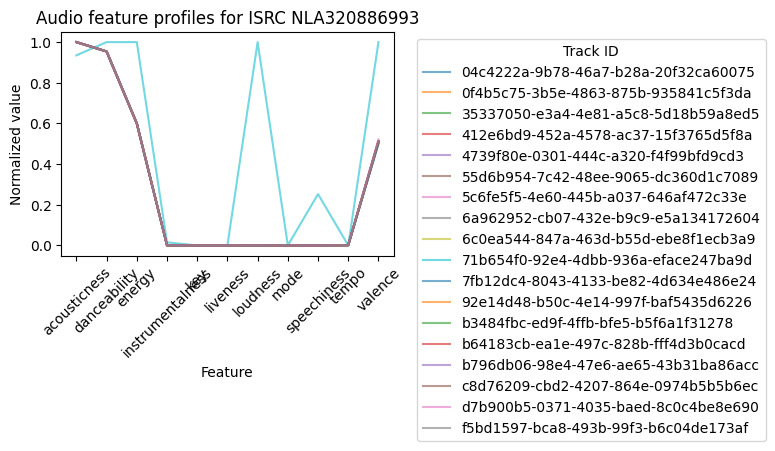

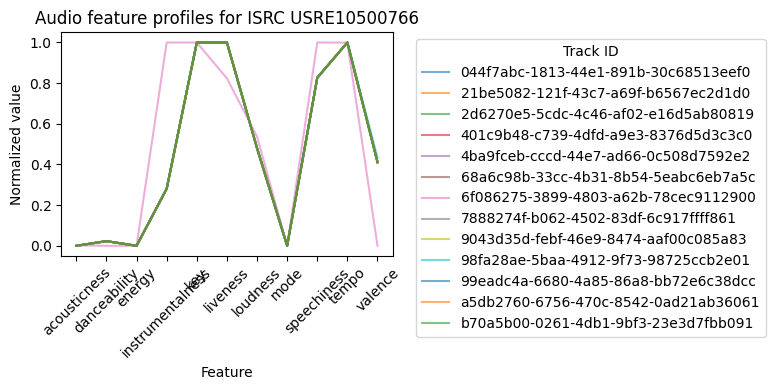

In [33]:
#we will plot the different versions of the same isrc to see if the difference between them is significant
for isrc, g_isrc in track_df_long.groupby("isrc"):
    plt.figure(figsize=(8, 4))

    for track_id, g_track in g_isrc.groupby("id"):
        plt.plot(
            g_track["feature"],
            g_track["value_norm"],
            label=track_id,
            alpha=0.6
        )

    plt.title(f"Audio feature profiles for ISRC {isrc}")
    plt.ylabel("Normalized value")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.legend(
    title="Track ID",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)
    plt.tight_layout()
    plt.show()

### As we can see the majority of the features overlap, but there are tracks that are one off,

In [16]:
#confirm that indeed the features overlap and it's not a plotting error
track_data_scaled.groupby("isrc")[features].nunique()
#we can see most features for the same isrc have 1-3 unique values only 

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
isrc,,,,,,,,,,,
NLA320886993,2,2,2,3,1,1,3,1,2,3,4
USRE10500766,2,2,1,2,1,2,2,1,2,2,3


In [17]:
#Also confirm std for the features
track_data_scaled.groupby("isrc")[features].std()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
isrc,,,,,,,,,,,
NLA320886993,0.015382,0.010837,0.094281,0.003432,0.0,0.000000,0.235597,0.0,0.059500,0.000333,0.115479
USRE10500766,0.000681,0.006376,0.000000,0.199506,0.0,0.048937,0.015829,0.0,0.048078,0.000222,0.114700


### We can see that audio features are highly consistent across most track versions sharing the same ISRC. A small number of versions exhibited substantial deviations, so we will use the median across versions to obtain a representative feature vector.”

#### Reccobeats uses rate limiting, we established by experimenting the limit is 40 ISRCs per request.


import requests
import pandas as pd
import time
from pathlib import Path


# Paths & setup files to record the info into

RAW_PATH = Path("data/raw/reccobeats_raw.parquet")
META_PATH = Path("data/metadata/fetched_isrcs.txt")

# Ensure directories exist
RAW_PATH.parent.mkdir(parents=True, exist_ok=True)
META_PATH.parent.mkdir(parents=True, exist_ok=True)

# Reccobeats API params
url = "https://api.reccobeats.com/v1/audio-features"
payload = {}
headers = {'Accept': 'application/json'}

MAX_BATCH = 40  # Reccobeats batch limit

def load_fetched_isrcs(path):
    """Load previously fetched ISRCs"""
    if path.exists():
        return set(path.read_text().splitlines())
    return set()

fetched_isrcs = load_fetched_isrcs(META_PATH)


def chunk_list(lst, size=MAX_BATCH):
    """Yield successive chunks of given size."""
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

def fetch_batch(batch):
    """
    Fetch audio features for a batch of ISRCs (<=MAX_BATCH).
    Keeps valid tracks even if some ISRCs fail.
    Retries missing ISRCs individually.
    """
    batch = [i.strip().upper() for i in batch if i.strip()]
    if not batch:
        print("Batch not generated")
        return []
    print("Fetching batch:", batch)


    params = {"ids": ",".join(batch)}
    try:
        response = requests.request("GET", url, headers=headers, data=payload, params=params)
        
        data = response.json()
        response.raise_for_status()
        
        content = data.get("content", [])
        print(f"Returned {len(content)} items")

        tracks = []
        for item in content:
            if "isrc" not in item:
                continue
            tracks.append(item)
            
    except Exception as e:
        print(f"❌ Batch request error: {e}")
        return []

    # Retry missing ISRCs individually
    fetched_in_batch = [t.get("isrc") for t in tracks if t.get("isrc")]
    missing = [i for i in batch if i not in fetched_in_batch]

    for isrc in missing:
        try:
            r = requests.request("GET", url, headers=headers, data=payload, params={"ids": [isrc]})
            r.raise_for_status()
            d = r.json()
            t = d.get("content", [])
            if t:
                tracks.extend(t)
            else:
                print(f"⚠️ No data returned for ISRC {isrc}")
        except Exception as e:
            print(f"❌ Error fetching ISRC {isrc}: {e}")

        time.sleep(0.5)  # polite pacing
    return tracks


# Load all ISRCs to fetch
all_isrcs = chart_df["ISRC"].dropna().unique().tolist()
remaining_isrcs = [i for i in all_isrcs if i not in fetched_isrcs]
print(f"Total ISRCs to fetch: {len(remaining_isrcs)}")


# Main fetching loop
for batch in chunk_list(remaining_isrcs, MAX_BATCH):
    print(f"\nFetching batch of {len(batch)} ISRCs...")
    tracks = fetch_batch(batch)

    if not tracks:
        print("⚠️ Entire batch failed, marking all ISRCs to avoid infinite retries.")
        # mark all as fetched to avoid infinite loop
        with META_PATH.open("a") as f:
            for isrc in batch:
                if isrc not in fetched_isrcs:
                    f.write(isrc + "\n")
                    fetched_isrcs.add(isrc)
        continue

    # Convert to DataFrame
    df_batch = pd.DataFrame(tracks)

    # Load the parquet if it exists
    if RAW_PATH.exists():
        df_existing = pd.read_parquet(RAW_PATH)
        df_all = pd.concat([df_existing, df_batch], ignore_index=True)
    else:
        df_all = df_batch

    # Save updated parquet
    df_all.to_parquet(RAW_PATH, index=False)

    # Update fetched ISRCs log
    with META_PATH.open("a") as f:
        for t in df_batch["isrc"]:
            if t not in fetched_isrcs:
                f.write(t + "\n")
                fetched_isrcs.add(t)

    print(f"✅ Saved {len(df_batch)} tracks, total saved so far: {len(df_all)}")
    time.sleep(1)  # polite pacing between batches
    
    #to ensure fetched_isrcs.txt file doesn't contain duplicates 
    assert len(fetched_isrcs) == len(set(fetched_isrcs)), (
    "❌ fetched_isrcs contains duplicates — bookkeeping corruption detected"
)

print("\n Fetch complete!")
print(f"Total tracks saved: {len(pd.read_parquet(RAW_PATH))}")



In [18]:
#read the resulting df with audio features
df = pd.read_parquet("data/raw/reccobeats_raw.parquet")
df.head()

,id,href,isrc,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,2d43e431-6377-41f5-919c-fe2c486bca40,https://open.spotify.com/track/1LHZMWefF9502NP...,US5Z51300295,0.000084,0.508,0.988,0.000000,1,0.2090,-3.613,0,0.1650,75.018,0.174
1,5089f4c7-db62-4db5-aa44-895a04616960,https://open.spotify.com/track/77yBGJUzzFC0nOC...,NLA320785927,0.000076,0.369,0.995,0.005890,0,0.2460,-2.584,0,0.1200,185.985,0.270
2,e492917e-d664-4e17-9237-2956e1ab17b1,https://open.spotify.com/track/56fiFTRrSiHHH3g...,NLA321900097,0.000437,0.336,0.978,0.000525,7,0.1380,-2.358,1,0.0846,129.842,0.496
3,39f2b7f9-7a08-4f08-b895-cf9029082d15,https://open.spotify.com/track/2ZsTRYllzIEVluS...,NLA321292440,0.000107,0.552,0.988,0.309000,1,0.8460,-2.555,0,0.0787,139.941,0.618
4,f06b1005-db96-44d5-939e-ed1afc7fe336,https://open.spotify.com/track/5UpDvqyZnhdWY16...,GBDHC2124401,0.000027,0.388,0.830,0.021200,3,0.0946,-3.035,0,0.0922,129.980,0.144


In [19]:
df["isrc"] = df["isrc"].str.upper().str.strip()
print(df.shape)
df.info()

(6943, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6943 entries, 0 to 6942
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6943 non-null   object 
 1   href              6943 non-null   object 
 2   isrc              6943 non-null   object 
 3   acousticness      6943 non-null   float64
 4   danceability      6943 non-null   float64
 5   energy            6943 non-null   float64
 6   instrumentalness  6943 non-null   float64
 7   key               6943 non-null   int64  
 8   liveness          6943 non-null   float64
 9   loudness          6943 non-null   float64
 10  mode              6943 non-null   int64  
 11  speechiness       6943 non-null   float64
 12  tempo             6943 non-null   float64
 13  valence           6943 non-null   float64
dtypes: float64(9), int64(2), object(3)
memory usage: 759.5+ KB


In [20]:
df.describe()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000,6943.000000
mean,0.008604,0.384350,0.934224,0.258559,5.283307,0.272450,-4.791770,0.629411,0.132095,127.904120,0.246658
std,0.062447,0.119696,0.087657,0.341379,3.607743,0.186564,2.235841,0.482997,0.073954,29.098642,0.157717
min,0.000000,0.071100,0.000268,0.000000,0.000000,0.020400,-33.532000,0.000000,0.025200,59.979000,0.000000
25%,0.000029,0.289000,0.924000,0.000332,1.000000,0.120000,-5.618000,0.000000,0.078600,105.068000,0.126000
50%,0.000128,0.397000,0.960000,0.029200,6.000000,0.245000,-4.461000,1.000000,0.115000,125.271000,0.214000
75%,0.000682,0.478000,0.981000,0.565500,8.000000,0.360000,-3.481000,1.000000,0.167500,148.023000,0.339000
max,0.995000,0.804000,1.000000,0.993000,11.000000,0.996000,6.455000,1.000000,0.564000,205.972000,0.975000


In [21]:
df[df['loudness']>0].count()

id                  23
href                23
isrc                23
acousticness        23
danceability        23
energy              23
instrumentalness    23
key                 23
liveness            23
loudness            23
mode                23
speechiness         23
tempo               23
valence             23
dtype: int64

We see that the values for most columns fall within the expected ranges based on the feature description provided by Reccobeats except for a small subset of tracks with loudness above 0. This is likely due to differences in loudness reference or averaging methodology used by the audio feature extraction pipeline. These values were retained to avoid arbitrary clipping and preserve consistency across the dataset.

In [22]:
#check how many unique ISRCs we fetched
df["isrc"].nunique()

4697

In [23]:
df["isrc"].value_counts().head(10)

isrc
NLA321292440    32
NLA321600033    21
NLA320682263    19
NLA320886993    18
NLA320682675    18
NLA322200172    18
NLA322000471    14
USRE10500766    13
NLA321500169    11
NLA320581159     9
Name: count, dtype: int64

#### Not all ISRCs were found on Reccobeats, but a good proportion was that should be sufficient for our predictions. We will analyze the fetched vs. unfetched isrc parameters to see if we introduced any bias.

In [24]:
fetched_isrcs = set(df['isrc'].unique())
#create status and year column for further analysis
chart_df['Status'] = chart_df['ISRC'].map(lambda x:"fetched" if x in fetched_isrcs else "missing")
chart_df["Year"] = chart_df["Release Date"].dt.year
chart_df.head()

,Track,Artists,Release Date,ISRC,Spotify Streams,Explicit Track,Status,Year
0,Psychosocial,Slipknot,2008-07-08,NLA320886993,808166393,0,fetched,2008
1,Stricken,Disturbed,2005-07-20,USRE10500766,466331168,0,fetched,2005
2,Unsainted,Slipknot,2019-05-16,NLA321900089,379175553,1,fetched,2019
3,Sanctified with Dynamite,Powerwolf,2011-07-29,USMBR1108247,62337875,0,fetched,2011
4,Nero Forte,Slipknot,2019-08-09,NLA321900097,205529233,1,fetched,2019


In [25]:
chart_df['Status'].value_counts()

Status
fetched    4697
missing    2065
Name: count, dtype: int64

In [28]:
chart_df.groupby('Status').median(numeric_only=True)


,Spotify Streams,Explicit Track,Year
Status,,,
fetched,165412.0,0.0,2023.0
missing,25637.0,0.0,2025.0


In [29]:
chart_df.groupby("Status")["Explicit Track"].mean()

Status
fetched    0.407281
missing    0.425666
Name: Explicit Track, dtype: float64

We can see that the tracks we found on Reccobeats are quite a bit more popular than the ones we didn't, also the missing tracks seem to be newer. There is no significant difference in terms of tracks explicitness. Let's visualize the differences between two groups

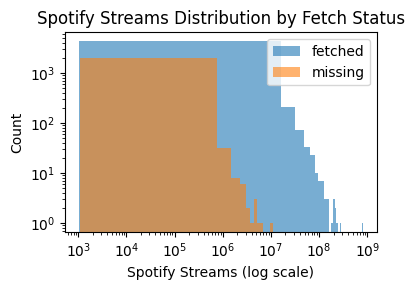

In [38]:
plt.figure(figsize=(4,3))
for status, g in chart_df.groupby("Status"):
    plt.hist(
        g["Spotify Streams"].dropna(),
        bins=50,
        alpha=0.6,
        label=status,
        log=True
    )
#we'll use log scaling to avoid dominance by high stream outliers
plt.xscale("log")
plt.xlabel("Spotify Streams (log scale)")
plt.ylabel("Count")
plt.title("Spotify Streams Distribution by Fetch Status")
plt.legend()
plt.tight_layout()
plt.show()



Based on the plot, the missing tracks are less popular, although there is still some coverage of lower popularity tracks among the fetched tracks. We will also create a boxplot to assess median and std of spotify streams

<Figure size 400x300 with 0 Axes>

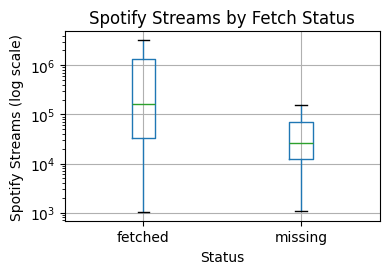

In [41]:
plt.figure()
chart_df.boxplot(
    column="Spotify Streams",
    by="Status",
    showfliers=False
)

plt.yscale("log")
plt.title("Spotify Streams by Fetch Status")
plt.suptitle("")
plt.ylabel("Spotify Streams (log scale)")
plt.tight_layout()
plt.show()

We can clearly see that the median popularity of fetched tracks is quite a bit higher that the median popularity of the missing tracks. The IQR of the missing tracks is tighter distributed around lower stream counts.

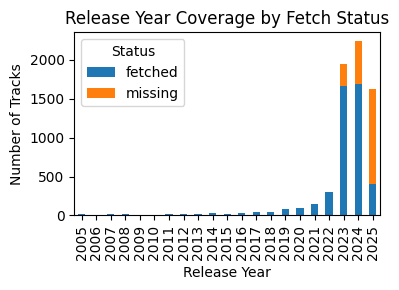

In [42]:
year_counts = (
   chart_df.groupby(["Year", "Status"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

year_counts.plot(kind="bar", stacked=True)

plt.xlabel("Release Year")
plt.ylabel("Number of Tracks")
plt.title("Release Year Coverage by Fetch Status")
plt.tight_layout()
plt.show()

Seems like we found the main difference between fetched and missing tracks. The missing tracks tend to be from recent years, especially 2025. Looks like Reccobeats did not quite update their platform yet. This can also explain the popularity bias. Since spotify streams are cumulative, later releases would tend to have fewer streams. We will exclude 2025 and plot the comparisons again.


<Figure size 400x300 with 0 Axes>

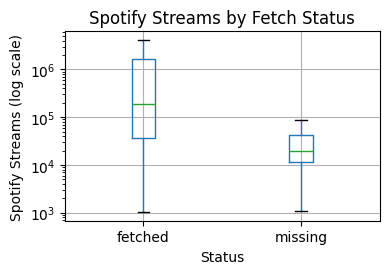

In [43]:
plt.figure()
chart_df[chart_df['Year']!=2025].boxplot(
    column="Spotify Streams",
    by="Status",
    showfliers=False
)

plt.yscale("log")
plt.title("Spotify Streams by Fetch Status")
plt.suptitle("")
plt.ylabel("Spotify Streams (log scale)")
plt.tight_layout()
plt.show()

After removing 2025, the remaining missing tracks distribution shifted even further towards the less popular tracks. So, we can conclude that Reccobeats API tends to be missing less popular or newer tracks.

In [44]:
#we'll group tracks in popularity bins to see if we have a god enough representation to predict our target
bins = [0, 50000, 250000,500000, 1000000,10000000, np.inf]
grouped = chart_df[(chart_df["Status"]=='fetched') & (chart_df['Year']!=2025)].groupby(pd.cut(chart_df["Spotify Streams"], 
                                                                 bins = bins, )).count()
print(grouped['Track'])

Spotify Streams
(0.0, 50000.0]             1282
(50000.0, 250000.0]        1028
(250000.0, 500000.0]        384
(500000.0, 1000000.0]       321
(1000000.0, 10000000.0]     753
(10000000.0, inf]           530
Name: Track, dtype: int64


/var/folders/l5/jbpyr_cx6q94tg1944sjg5j00000gn/T/ipykernel_4055/2345107934.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = chart_df[(chart_df["Status"]=='fetched') & (chart_df['Year']!=2025)].groupby(pd.cut(chart_df["Spotify Streams"],


In [45]:
chart_df[chart_df['Status']=='fetched'].count()

Track              4697
Artists            4697
Release Date       4697
ISRC               4697
Spotify Streams    4697
Explicit Track     4697
Status             4697
Year               4697
dtype: int64

In [46]:
#convert categorical variables to object data type so we can calculate mode later on
df['key'] = df['key'].astype('object')
df['mode'] = df['mode'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6943 entries, 0 to 6942
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6943 non-null   object 
 1   href              6943 non-null   object 
 2   isrc              6943 non-null   object 
 3   acousticness      6943 non-null   float64
 4   danceability      6943 non-null   float64
 5   energy            6943 non-null   float64
 6   instrumentalness  6943 non-null   float64
 7   key               6943 non-null   object 
 8   liveness          6943 non-null   float64
 9   loudness          6943 non-null   float64
 10  mode              6943 non-null   object 
 11  speechiness       6943 non-null   float64
 12  tempo             6943 non-null   float64
 13  valence           6943 non-null   float64
dtypes: float64(9), object(5)
memory usage: 759.5+ KB


### For the purposes of training our model we will only be using one set of audio features for each ISRC. Where we have multiple versions of the same ISRC, we will calculate average audio feature values. As we established earlier, different versions tend to have highly overlapping audio features, so using median for numerical features and mode for categorical features should give us a representative feature vector.

In [47]:
#calculate median for numerical columns and mode for categorical columns.
cat = ['key', 'mode']
num =  [col for col in df.columns[3:].to_list() if col not in cat]

#function for calculating mode as  pandas groupby does not have a built-in option
safe_mode = lambda x: x.mode().iloc[0] if not x.mode().empty else None

#Build the aggregation dictionary
agg_dict = {col: 'median' for col in num} |{col: safe_mode for col in cat}

#Apply the groupby
df_median = df.groupby('isrc').agg(agg_dict)
df_median

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
isrc,,,,,,,,,,,
AEA2M2452931,0.000011,0.221,0.981,0.820000,0.331,-5.391,0.0993,180.461,0.335,6,0
AEA2M2452932,0.000214,0.188,0.974,0.904000,0.102,-4.888,0.0945,134.542,0.295,7,1
AEA2W2504606,0.003590,0.315,0.992,0.000000,0.347,-2.084,0.1700,87.552,0.306,0,0
AEA2W2504610,0.000856,0.400,0.992,0.000000,0.157,-1.543,0.2150,175.015,0.218,1,1
ATN260929004,0.000706,0.477,0.965,0.000001,0.301,-3.245,0.1550,110.015,0.584,10,0
...,...,...,...,...,...,...,...,...,...,...,...
USYFZ2548008,0.000068,0.553,0.934,0.650000,0.413,-3.068,0.0688,94.983,0.476,1,1
USYFZ2548010,0.000483,0.421,0.916,0.000122,0.403,-4.119,0.0516,130.102,0.157,11,0
USYWT0700020,0.000643,0.315,0.863,0.601000,0.115,-7.943,0.0681,75.985,0.507,0,1


We can see from the shape of the dataframe that it only contains unique isrcs values

In [48]:
#doublecheck if isrcs are unique
df_median.index.is_unique

True

In [49]:
#doublecheck if medians are calculated correctly

def check (col):
     return df.groupby('isrc')[col].median().equals(df_median[col])
for col in num:
    assert check, f"Mismatch in {col}"

In [50]:
#doublecheck if modes are calculated correctly
def mode_set(x):
    return set(x.mode())

mode_wrong = []

for isrc, g in df.groupby('isrc'):
    for col in cat:
        if df_median.loc[isrc, col] not in mode_set(g[col]):
            mode_wrong.append((isrc, col))
print(mode_wrong)

[]


In [ ]:
#combine chartmetric dataframe and reccobeats data
df_combined = chart_df[chart_df['Status']=='fetched'].set_index(keys = 'ISRC')
df_combined=df_combined.merge(df_median, left_index = True, right_index = True)

In [ ]:
df_combined.head()

,Track,Artists,Release Date,Spotify Streams,Explicit Track,Status,Year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
NLA320886993,Psychosocial,Slipknot,2008-07-08,808166393,0,fetched,2008,0.002690,0.568,0.981,0.002770,0.0243,-3.888,0.0887,135.148,0.308,2,1
USRE10500766,Stricken,Disturbed,2005-07-20,466331168,0,fetched,2005,0.000085,0.406,0.969,0.011100,0.2680,-2.938,0.1650,173.878,0.299,8,1
NLA321900089,Unsainted,Slipknot,2019-05-16,379175553,1,fetched,2019,0.000118,0.427,0.947,0.025500,0.0604,-2.188,0.0469,101.307,0.237,7,1
USMBR1108247,Sanctified with Dynamite,Powerwolf,2011-07-29,62337875,0,fetched,2011,0.000224,0.235,0.968,0.000000,0.2250,-4.758,0.0901,87.955,0.277,1,0
NLA321900097,Nero Forte,Slipknot,2019-08-09,205529233,1,fetched,2019,0.000437,0.336,0.978,0.000525,0.1380,-2.358,0.0846,129.842,0.496,7,1


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4697 entries, NLA320886993 to QZNWT2358304
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Track             4697 non-null   object        
 1   Artists           4697 non-null   object        
 2   Release Date      4697 non-null   datetime64[ns]
 3   Spotify Streams   4697 non-null   Int64         
 4   Explicit Track    4697 non-null   int64         
 5   Status            4697 non-null   object        
 6   Year              4697 non-null   int32         
 7   acousticness      4697 non-null   float64       
 8   danceability      4697 non-null   float64       
 9   energy            4697 non-null   float64       
 10  instrumentalness  4697 non-null   float64       
 11  liveness          4697 non-null   float64       
 12  loudness          4697 non-null   float64       
 13  speechiness       4697 non-null   float64       
 14  tempo     

No null values, and we can see that the resulting dataframe cast "key" and "mode" data back to integer, which is actually what we want for modelling.

In [ ]:
#drop "Status" column
df_combined = df_combined.drop(labels='Status',axis = 1)
df_combined.head()

,Track,Artists,Release Date,Spotify Streams,Explicit Track,Year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
NLA320886993,Psychosocial,Slipknot,2008-07-08,808166393,0,2008,0.002690,0.568,0.981,0.002770,0.0243,-3.888,0.0887,135.148,0.308,2,1
USRE10500766,Stricken,Disturbed,2005-07-20,466331168,0,2005,0.000085,0.406,0.969,0.011100,0.2680,-2.938,0.1650,173.878,0.299,8,1
NLA321900089,Unsainted,Slipknot,2019-05-16,379175553,1,2019,0.000118,0.427,0.947,0.025500,0.0604,-2.188,0.0469,101.307,0.237,7,1
USMBR1108247,Sanctified with Dynamite,Powerwolf,2011-07-29,62337875,0,2011,0.000224,0.235,0.968,0.000000,0.2250,-4.758,0.0901,87.955,0.277,1,0
NLA321900097,Nero Forte,Slipknot,2019-08-09,205529233,1,2019,0.000437,0.336,0.978,0.000525,0.1380,-2.358,0.0846,129.842,0.496,7,1


#### We currently have a total number of Spotify streams as of January 28,2026. We established earlier that average monthly streams would be a better measurement of success, as the total number of streams is cumulative and tracks released in earlier years would accumulate a higher number of streams without necessarily being more successful. Hence for our target we will calculate the average monthly number of streams

In [ ]:
#create variable for the date when we pulled data
pull_date = datetime.datetime(2026,1,28)

days_since_release = (pull_date - df_combined["Release Date"]).dt.days

#Avg days in the month is a constant that equals 30.44
months_since_release = days_since_release / 30.44

#calculate average monthly streams
df_combined["avg_monthly_streams"] = (
    df_combined["Spotify Streams"] / months_since_release)

df_combined.head()

,Track,Artists,Release Date,Spotify Streams,Explicit Track,Year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,avg_monthly_streams
NLA320886993,Psychosocial,Slipknot,2008-07-08,808166393,0,2008,0.002690,0.568,0.981,0.002770,0.0243,-3.888,0.0887,135.148,0.308,2,1,3836049.431299
USRE10500766,Stricken,Disturbed,2005-07-20,466331168,0,2005,0.000085,0.406,0.969,0.011100,0.2680,-2.938,0.1650,173.878,0.299,8,1,1893440.143247
NLA321900089,Unsainted,Slipknot,2019-05-16,379175553,1,2019,0.000118,0.427,0.947,0.025500,0.0604,-2.188,0.0469,101.307,0.237,7,1,4712986.457052
USMBR1108247,Sanctified with Dynamite,Powerwolf,2011-07-29,62337875,0,2011,0.000224,0.235,0.968,0.000000,0.2250,-4.758,0.0901,87.955,0.277,1,0,358233.889938
NLA321900097,Nero Forte,Slipknot,2019-08-09,205529233,1,2019,0.000437,0.336,0.978,0.000525,0.1380,-2.358,0.0846,129.842,0.496,7,1,2646493.169425


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4697 entries, NLA320886993 to QZNWT2358304
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Track                4697 non-null   object        
 1   Artists              4697 non-null   object        
 2   Release Date         4697 non-null   datetime64[ns]
 3   Spotify Streams      4697 non-null   Int64         
 4   Explicit Track       4697 non-null   int64         
 5   Year                 4697 non-null   int32         
 6   acousticness         4697 non-null   float64       
 7   danceability         4697 non-null   float64       
 8   energy               4697 non-null   float64       
 9   instrumentalness     4697 non-null   float64       
 10  liveness             4697 non-null   float64       
 11  loudness             4697 non-null   float64       
 12  speechiness          4697 non-null   float64       
 13  tempo              

We can now drop the redundant features Spotify Streams and Release date, as we extacted the info we wanted. We will also drop track name (as this is just an identifier), and Artist Name as we believe it will introduce bias - average streams would strongly correlate with the artist's popularity. Listeners are far more likely to check out a new track of a big artist due to brand name, visibility and marketing efforts.

<Axes: >

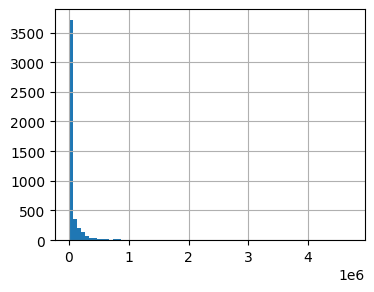

In [122]:
#create df for EDA
df_eda = df_combined.drop(labels=['Spotify Streams', 'Release Date','Track','Artists'], axis = 1)
df_eda['avg_monthly_streams'].hist(bins=70)

We should create a column of avg_log_streams_month for EDA and potentially modelling. Using log will help to smooth the influence of high stream outliers.

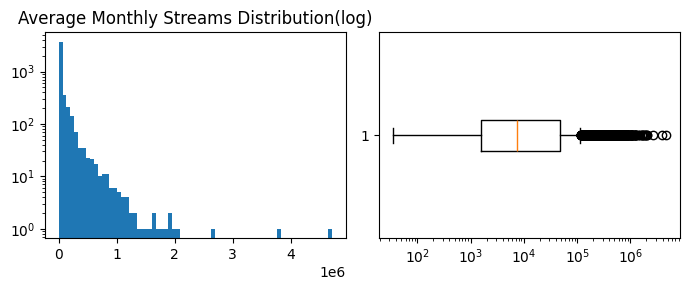

In [124]:
df_eda['log_avg_stream_mth'] = np.log(df_eda['avg_monthly_streams'])
#plot distribution of log avg monthly streams using log scale so the plot is not overshadowed by high stream outliers
fig, axes = plt.subplots(
    1, 2,
    figsize=(7,3))

# Histogram - 70 bins is approximately sq. root of # of observations 
axes[0].hist(df_eda['avg_monthly_streams'], bins=70)
axes[0].set_yscale('log')
axes[0].set_title("Average Monthly Streams Distribution(log)")


# Boxplot
axes[1].boxplot(df_eda['avg_monthly_streams'], vert=False)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

Based on the histogram and the box plot, the distribution is skewed to the right, very heavy tailed (even on log scale) meaning the majority of tracks do not get high volumes of streams, while there exists a number of outliers that accumulate exponentially larger number of streams. we will have to use log scale for training to reduce the effect of outliers.

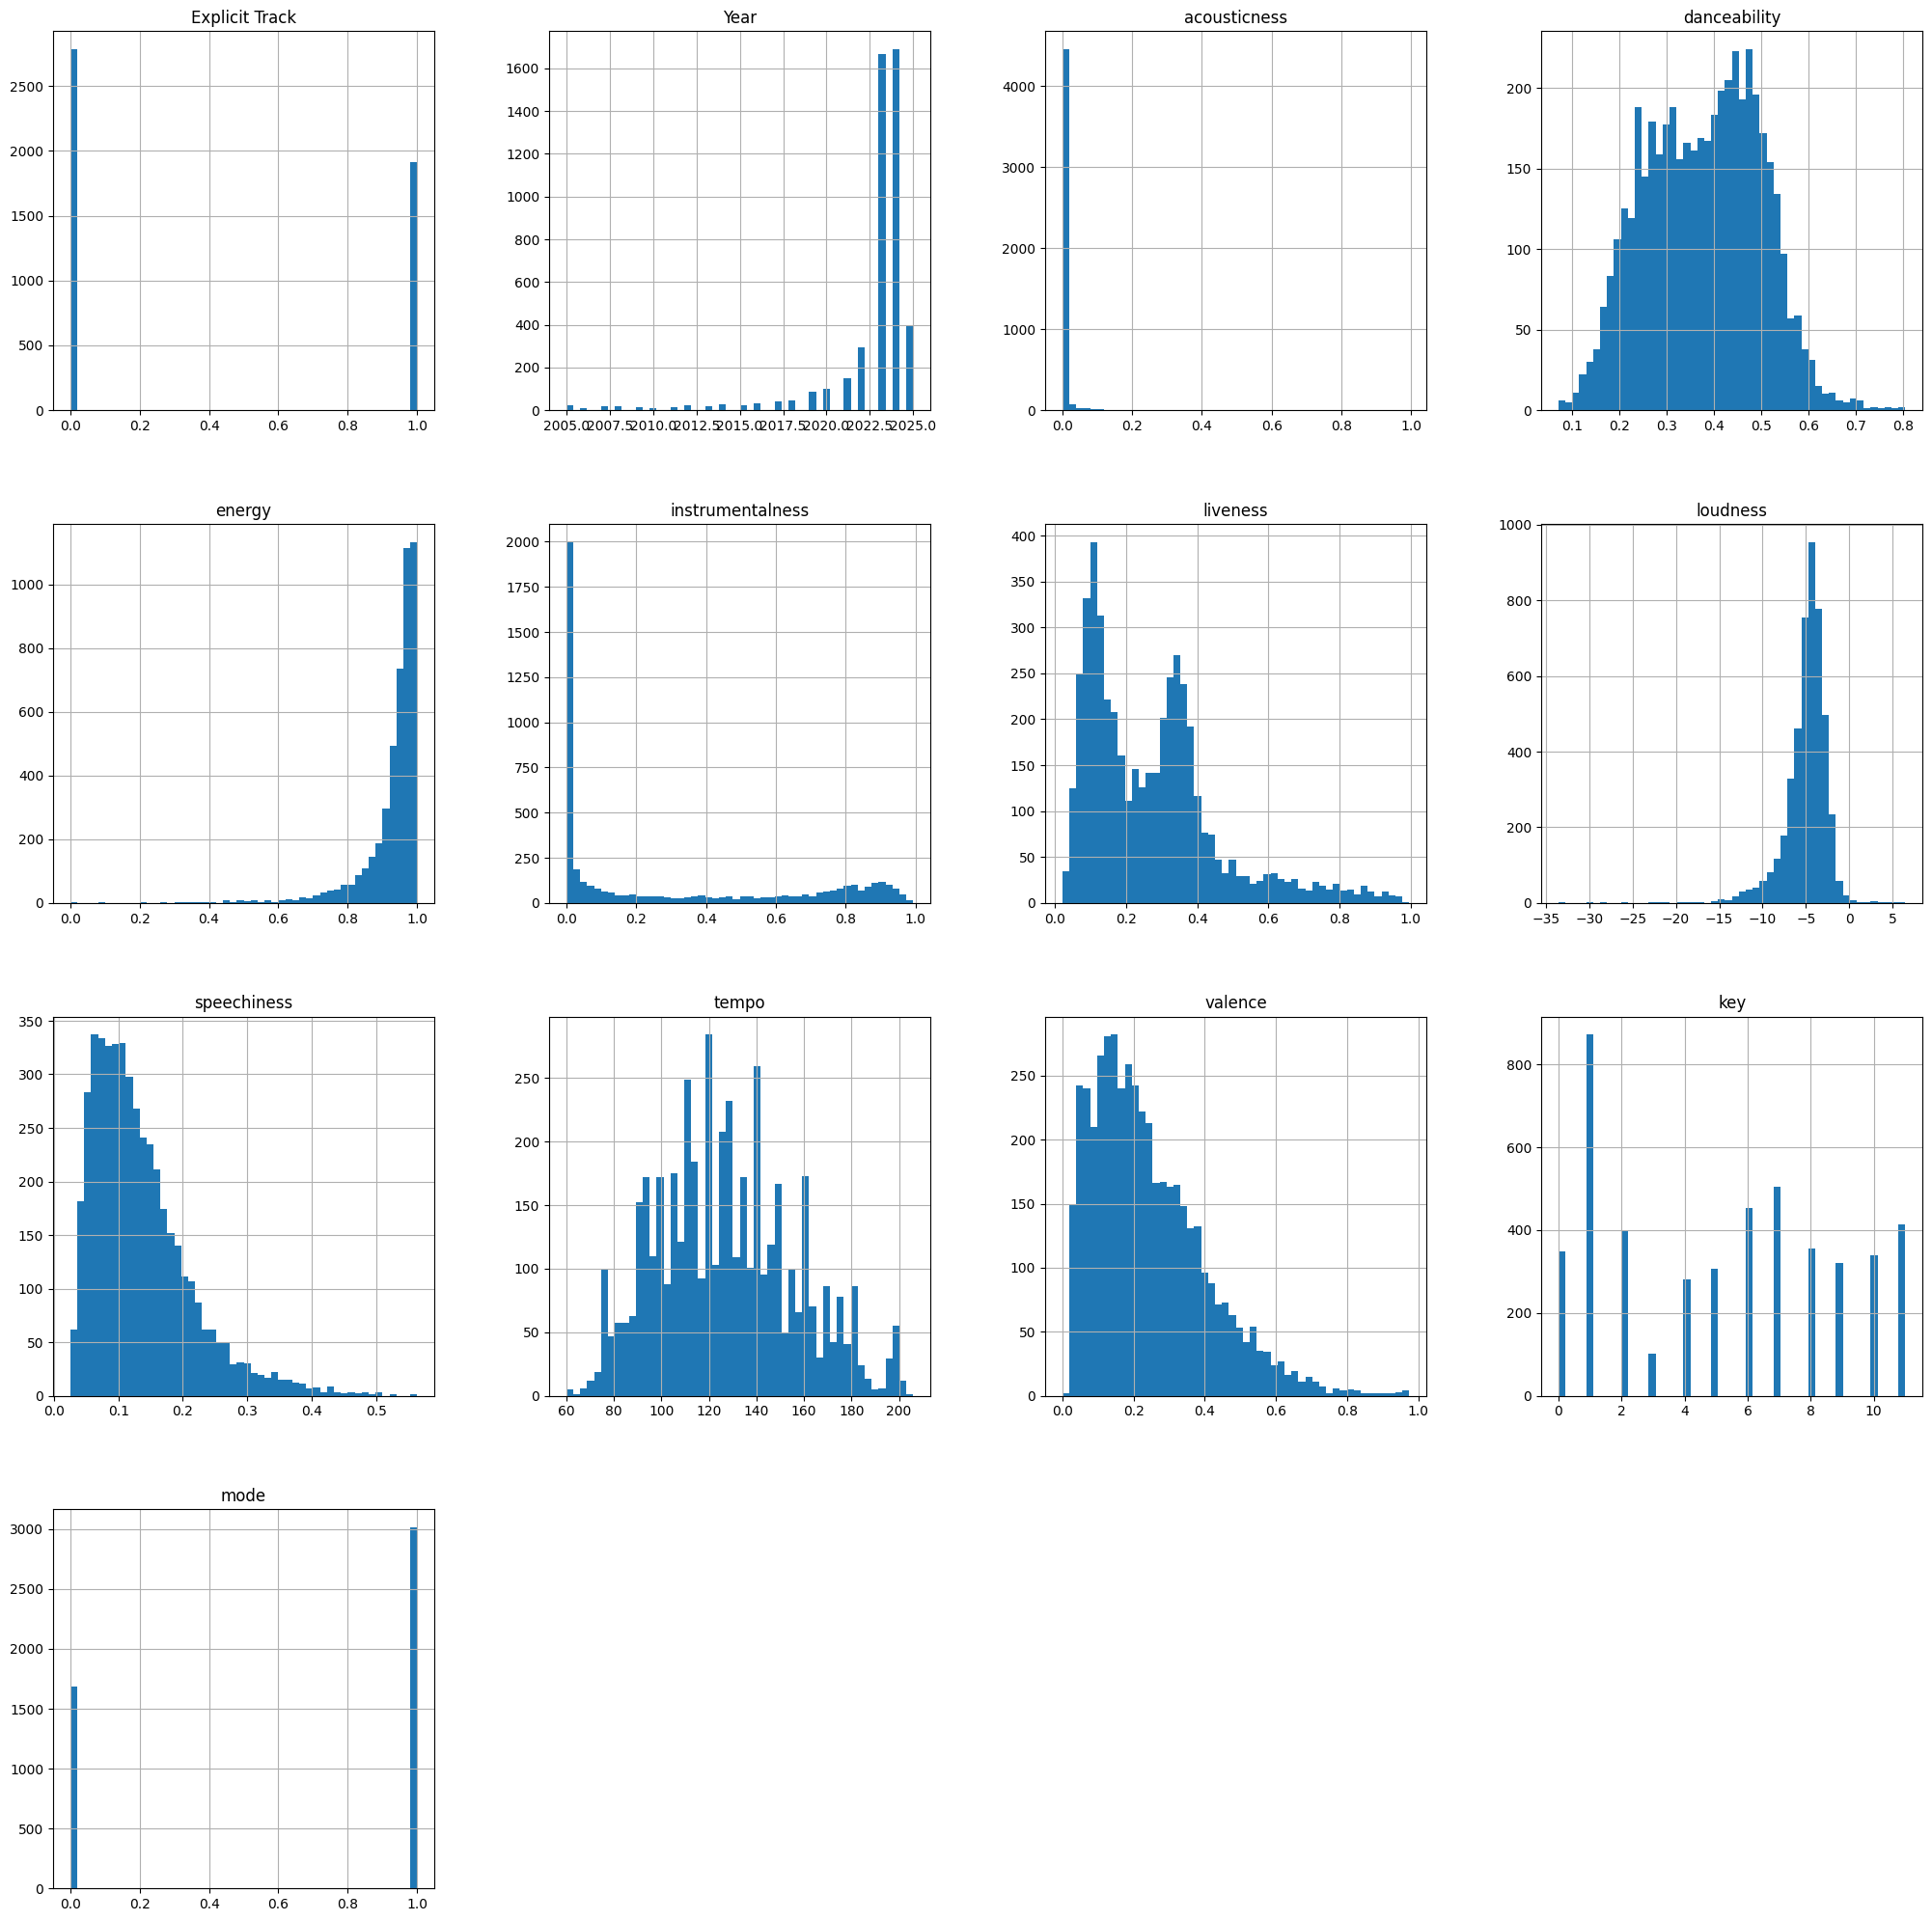

In [126]:
#We will plot all features to get an idea of their distributions
df_eda.iloc[:,:-2].hist(bins=50, figsize=(25,25));

We can see that the majority of features have skewed distributions with certain value and value ranges dominating that feature's data space.
1. The majority of the tracks are from the more recent years, which could be due to teh fact that it is easier now to start and grow a band compared to early 2000s. The development of social media, music processing and generating software (such as programmable instruments, AI tools for mixing and mastering) have lowered the entering cost for music creation and marketing.
2. The majority of tracks are not acoustic, which represents the extreme metal genres well, as electric instruments, such as electric and base guitars are heavily used. 
3. Danceability and tempo 
 2. Liveness has a bimodal distribution. Based on the field description, values above 0.8 suggest a live track. However we are seeing peaks at 0.1 and 0.4, both are well under the 0.8 mark. It is possible that the distinction is between high-quality production recordings, and more amateur recordings that would have more background noise. Another aspect is that one of the genres pulled for this research is slam death metal, where one of the features of the genre is a less refined, distorted, muddy, raw demo quality of recordings, which could contribute to the increased "liveness" parameter of these tracks.

In [109]:
corr = df_eda[['danceability','tempo']]
corr.head()

,danceability,tempo
NLA320886993,0.568,135.148
USRE10500766,0.406,173.878
NLA321900089,0.427,101.307
USMBR1108247,0.235,87.955
NLA321900097,0.336,129.842


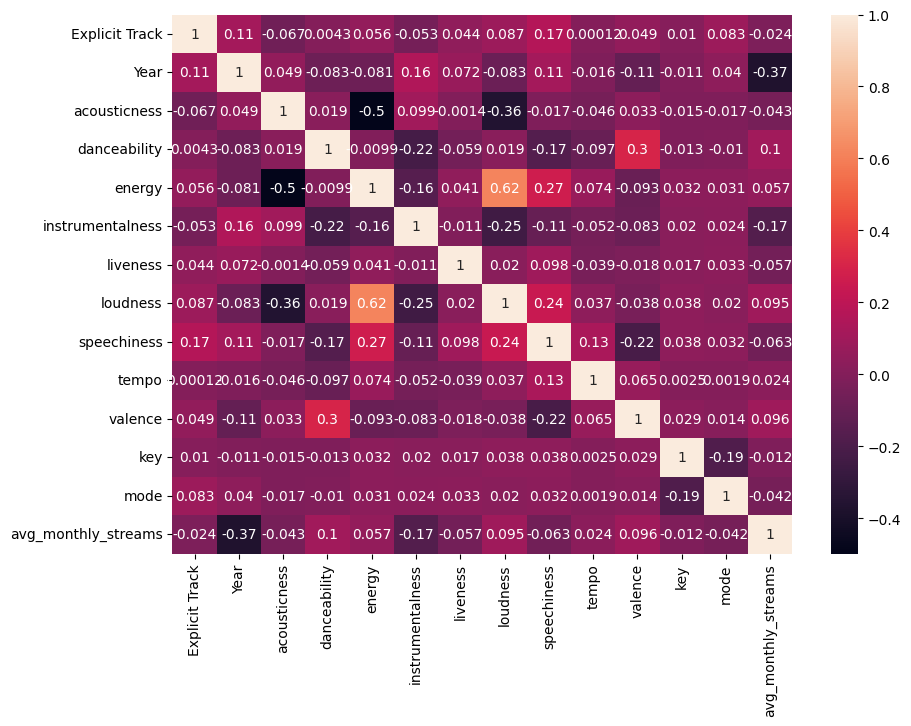

In [119]:
co_mtx = df_eda.corr(numeric_only=True)
plt.figure(figsize = (10,7))
sns.heatmap(co_mtx, annot = True, )
plt.show()

In [ ]:
from platform import python_version
print(python_version())



: 

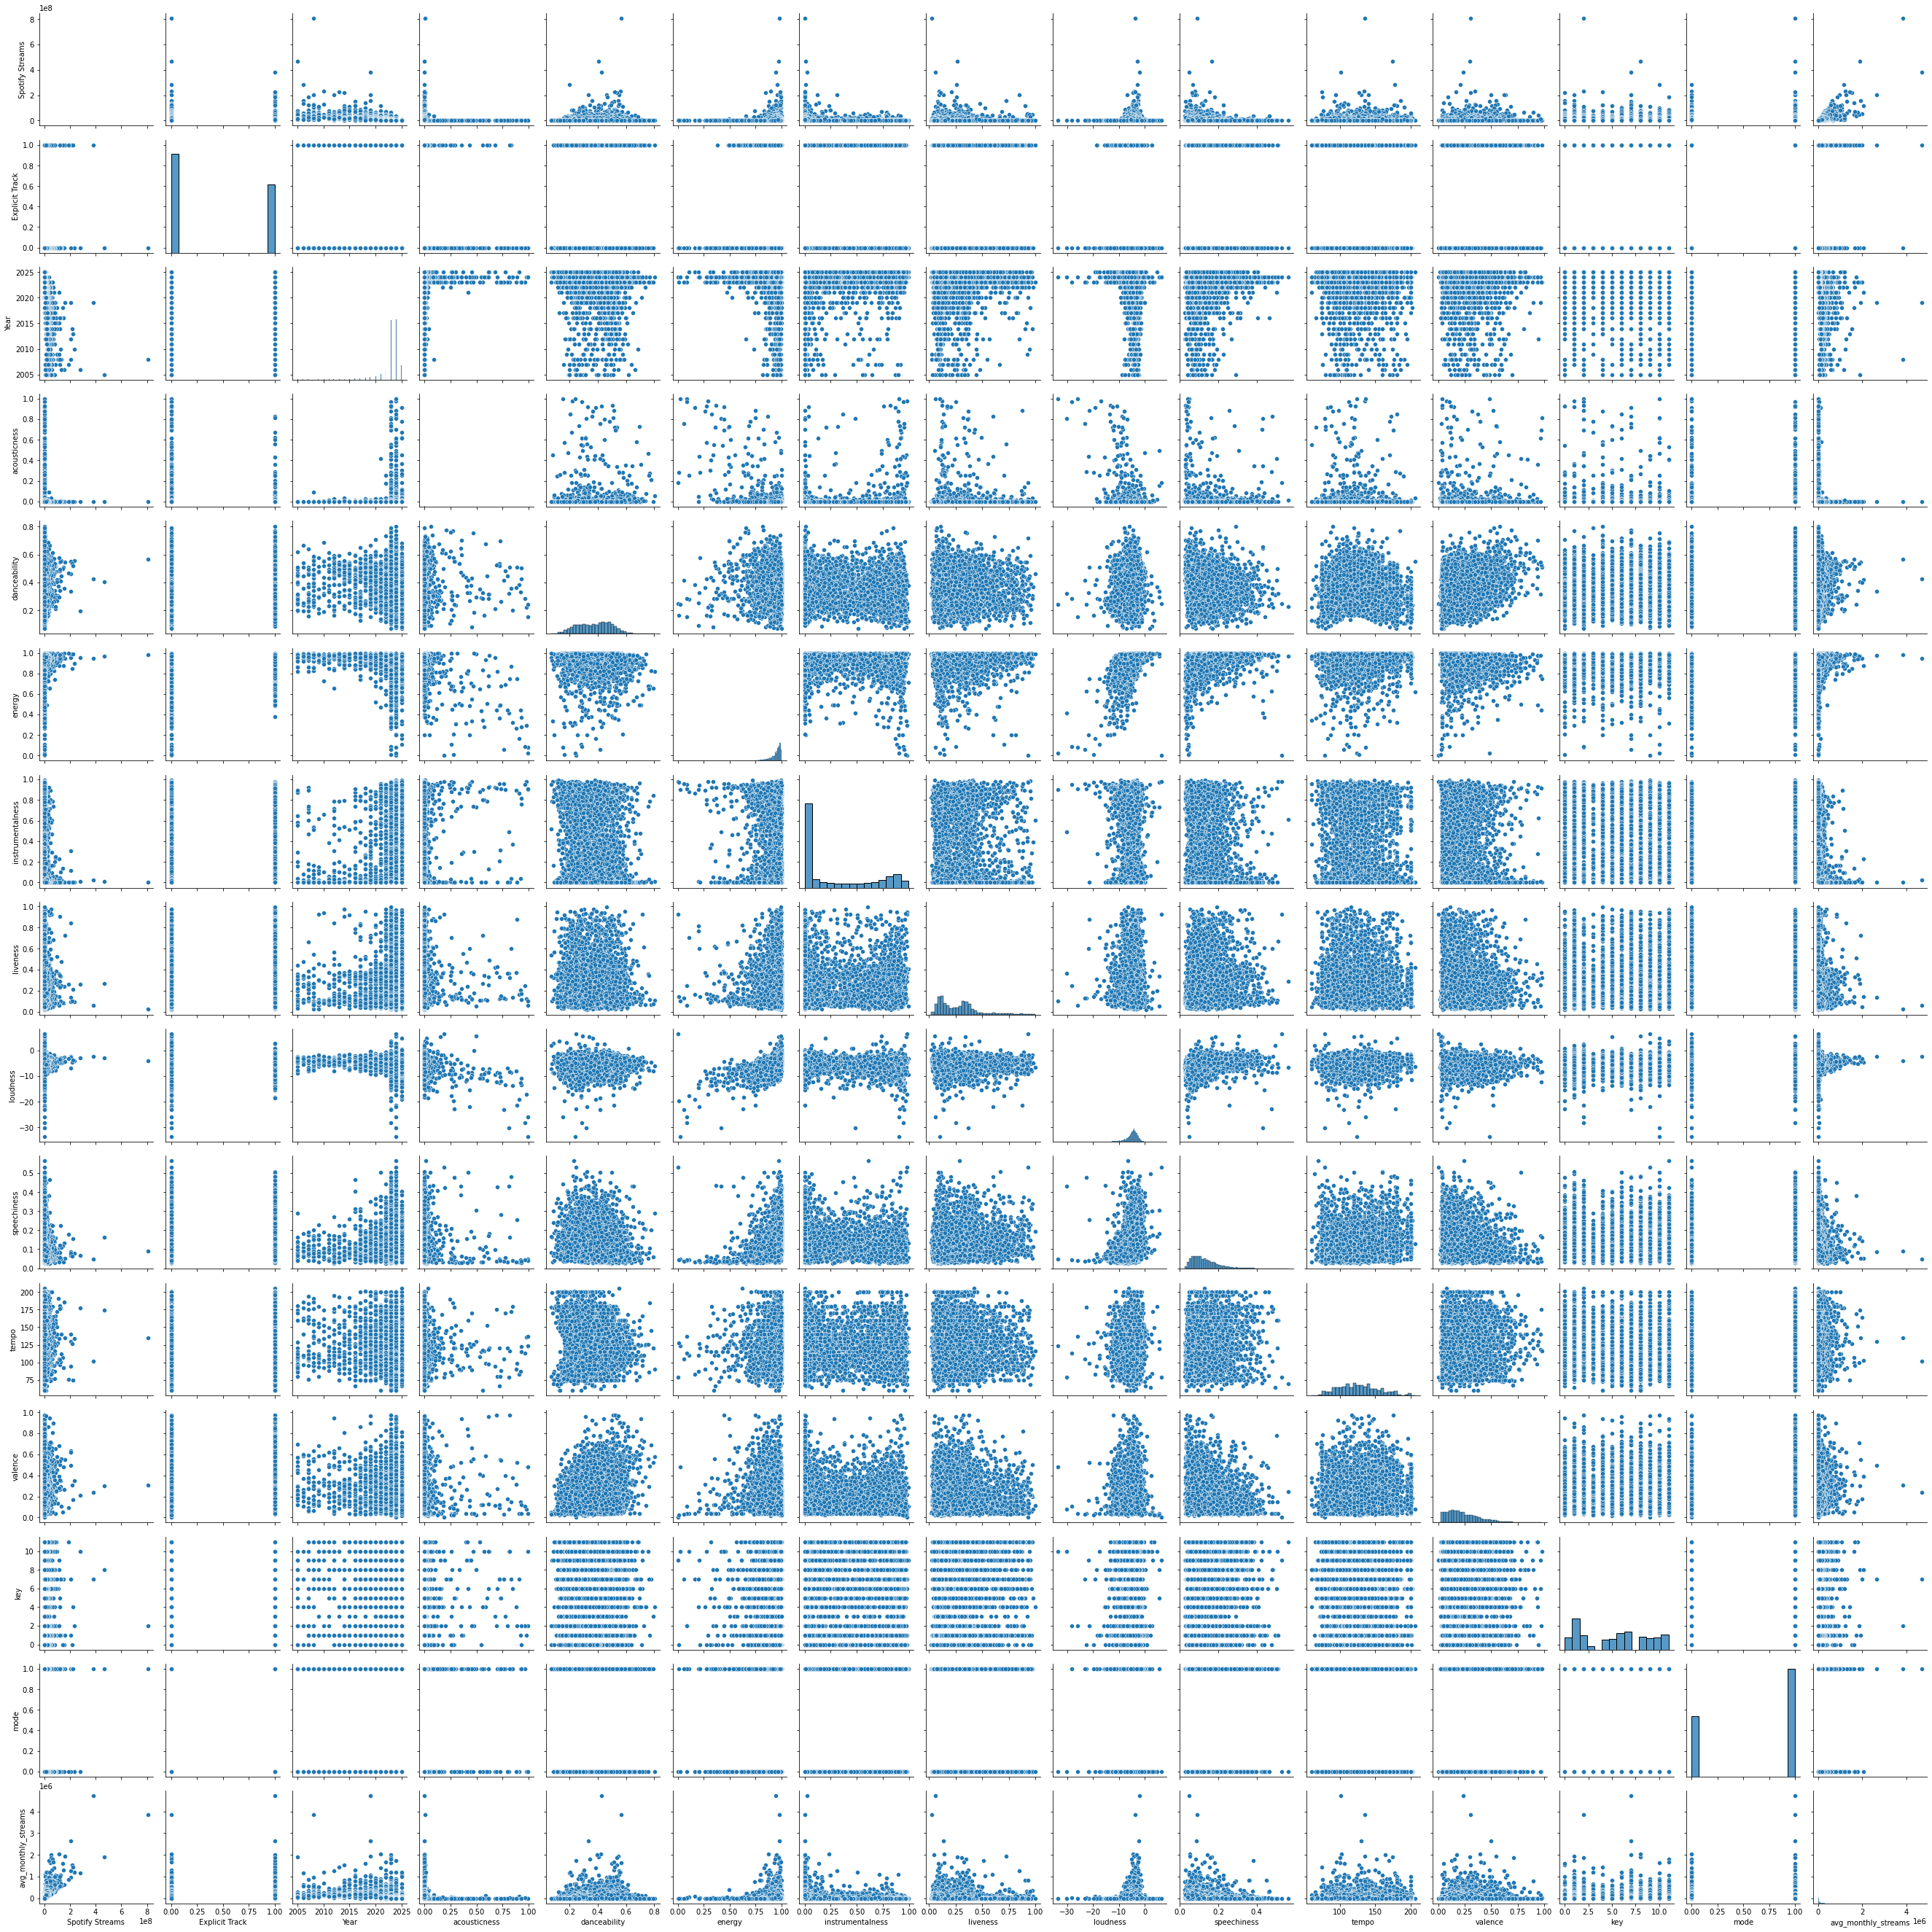

In [ ]:
g = sns.pairplot(df_combined)
g.savefig("seaborn pairplot.png")

In [ ]:
df_combined.describe()

,Spotify Streams,Explicit Track,Year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,avg_monthly_streams
count,4.697000e+03,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4697.000000,4.697000e+03
mean,4.985581e+06,0.407281,2022.607835,0.011321,0.377232,0.927937,0.298280,0.271912,-4.957506,0.134454,127.137620,0.242281,5.229508,0.641473,6.694313e+04
std,2.152313e+07,0.491380,2.991457,0.073182,0.120068,0.097092,0.355650,0.184828,2.446306,0.076278,28.904699,0.158683,3.601373,0.479619,1.904265e+05
min,1.027000e+03,0.000000,2005.000000,0.000000,0.071100,0.000268,0.000000,0.020400,-33.532000,0.025200,59.979000,0.000000,0.000000,0.000000,3.489788e+01
25%,3.252800e+04,0.000000,2023.000000,0.000029,0.282000,0.918000,0.000594,0.120000,-5.857000,0.078500,105.050000,0.121000,1.000000,0.000000,1.540219e+03
50%,1.654120e+05,0.000000,2023.000000,0.000141,0.384000,0.958000,0.068000,0.243000,-4.557000,0.117000,125.029000,0.208000,6.000000,1.000000,7.300104e+03
75%,1.323991e+06,1.000000,2024.000000,0.000783,0.470000,0.980000,0.676000,0.361000,-3.522000,0.171000,145.913000,0.335000,8.000000,1.000000,4.725075e+04
max,8.081664e+08,1.000000,2025.000000,0.995000,0.804000,1.000000,0.993000,0.996000,6.455000,0.564000,205.972000,0.975000,11.000000,1.000000,4.712986e+06


In [ ]:
col_names = df_combined.columns.to_list()
target = col_names.pop()
col_names

['Track',
 'Artists',
 'Release Date',
 'Spotify Streams',
 'Explicit Track',
 'Year',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'key',
 'mode']

In [ ]:
#define numerical categorical and temporal features:

num  = col_names[6:-2]
temp = ['Release Date','Year']
cat = list(name for name in col_names[4:] if name not in temp and name not in num)
cat

['Explicit Track', 'key', 'mode']

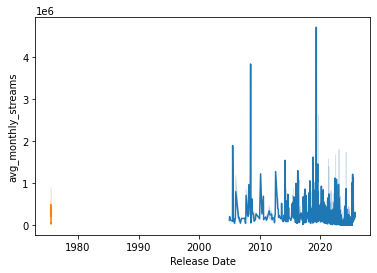

In [ ]:
for val in temp:
    sns.lineplot(data=df_combined,x=val,y='avg_monthly_streams')



In [ ]:
df_combined['avg_monthly_streams']

NLA320886993    3836049.431299
USRE10500766    1893440.143247
NLA321900089    4712986.457052
USMBR1108247     358233.889938
NLA321900097    2646493.169425
                     ...      
QZMEM2325801        378.178305
TCAFU2148149      22004.712106
DE1AH2202702      71900.550938
ATN262092201      153712.74063
QZNWT2358304         46.150968
Name: avg_monthly_streams, Length: 4697, dtype: Float64

<AxesSubplot:xlabel='Year'>

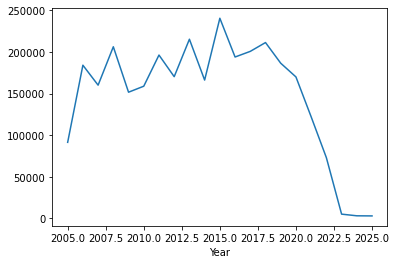

In [ ]:
df_combined.groupby('Year')[target].median().plot()

In [ ]:
df_combined

,Track,Artists,Release Date,Spotify Streams,Explicit Track,Year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,avg_monthly_streams
NLA320886993,Psychosocial,Slipknot,2008-07-08,808166393,0,2008,0.002690,0.568,0.981,0.002770,0.0243,-3.888,0.0887,135.148,0.308,2,1,3836049.431299
USRE10500766,Stricken,Disturbed,2005-07-20,466331168,0,2005,0.000085,0.406,0.969,0.011100,0.2680,-2.938,0.1650,173.878,0.299,8,1,1893440.143247
NLA321900089,Unsainted,Slipknot,2019-05-16,379175553,1,2019,0.000118,0.427,0.947,0.025500,0.0604,-2.188,0.0469,101.307,0.237,7,1,4712986.457052
USMBR1108247,Sanctified with Dynamite,Powerwolf,2011-07-29,62337875,0,2011,0.000224,0.235,0.968,0.000000,0.2250,-4.758,0.0901,87.955,0.277,1,0,358233.889938
NLA321900097,Nero Forte,Slipknot,2019-08-09,205529233,1,2019,0.000437,0.336,0.978,0.000525,0.1380,-2.358,0.0846,129.842,0.496,7,1,2646493.169425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
QZMEM2325801,Curbside Homicide,State of Filth,2023-06-29,11728,1,2023,0.000083,0.506,0.914,0.147000,0.3730,-5.444,0.3100,75.081,0.412,0,1,378.178305
TCAFU2148149,Resin Scraper,Bodybox,2021-09-30,1142886,1,2021,0.000004,0.299,0.940,0.674000,0.0429,-4.529,0.1250,79.681,0.577,10,0,22004.712106
DE1AH2202702,On The Dark Waters,Amorphis,2022-01-28,3450943,0,2022,0.000027,0.298,0.971,0.000587,0.3340,-5.113,0.0671,123.972,0.289,9,0,71900.550938
ATN262092201,Treasure Chest Party Quest,Alestorm,2020-04-02,10740703,1,2020,0.000174,0.492,0.964,0.000023,0.4690,-5.430,0.0628,75.079,0.535,5,0,153712.74063
